# Final Processing
The final processing stage requires:
1. Quick validation of catalogues and Bayesian Pvalue maps
2. Skewness level
3. Adding flag to catalogue

In [1]:
import seaborn as sns
from astropy.table import Table,  join
%matplotlib inline
import numpy as np
import pylab as plt

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Read tables

In [2]:
cat=Table.read('./data/dmu26_XID+SPIRE_GAMA-15_cat.fits')
from astropy import units as u
cat['RA'].unit=u.deg
cat['Dec'].unit=u.deg

In [3]:
cat[0:10]

HELP_ID,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500
,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
HELP_J142114.713-022456.632,215.31130406710292,-2.4157311228465796,0.5620979,1.1425444,0.16527699,0.5658127,1.154209,0.18378635,0.9746672,2.008064,0.28607625,-0.3031987,-0.6144895,-1.661693,0.018997375,0.02673857,0.043522593,0.999157,0.9993768,1.0000762,3474.019,2479.8357,2566.7473,0.0,0.0,0.0
HELP_J142115.463-022453.614,215.3144283598329,-2.4148928070077798,0.32438964,0.6919618,0.10139039,0.377513,0.82000655,0.10785132,0.57965344,1.2316642,0.17850618,-0.3031987,-0.6144895,-1.661693,0.018997375,0.02673857,0.043522593,0.99864084,0.9984512,1.0017759,3284.7715,2381.9768,2028.9357,0.0,0.0,0.0
HELP_J142116.253-022448.612,215.3177189174809,-2.4135032760164497,0.37506503,0.7946563,0.11586132,0.44195515,0.8998486,0.14606278,0.6248754,1.2915056,0.1731401,-0.3031987,-0.6144895,-1.661693,0.018997375,0.02673857,0.043522593,0.99856246,0.9991622,0.99959815,2780.7617,2348.3328,1853.3527,0.0,0.0,0.0
HELP_J142116.556-022407.621,215.3189838102919,-2.40211681477521,0.35964614,0.768197,0.10356134,0.4582681,0.8949324,0.14461455,0.6062988,1.1998781,0.18119647,-0.3031987,-0.6144895,-1.661693,0.018997375,0.02673857,0.043522593,0.99895906,1.0013123,1.0010389,2169.3162,2172.677,2044.5455,0.0,0.0,0.0
HELP_J142117.128-022410.414,215.32136857414193,-2.4028927292221396,0.39912915,0.80303824,0.118727446,0.5141071,0.94937223,0.16758715,0.74700224,1.3913813,0.27483287,-0.3031987,-0.6144895,-1.661693,0.018997375,0.02673857,0.043522593,0.99929166,1.000524,1.0008578,2764.2063,2451.2737,1804.162,0.0,0.0,0.0
HELP_J142117.382-022449.913,215.32242517076492,-2.41386464825607,0.47549,0.8551274,0.17798387,0.5714927,1.0325149,0.20438515,0.8276074,1.4492446,0.31646618,-0.3031987,-0.6144895,-1.661693,0.018997375,0.02673857,0.043522593,0.99973464,0.99882895,0.9996087,2459.7488,2446.081,1785.273,0.0,0.0,0.0
HELP_J142118.091-022349.653,215.32537802058692,-2.3971258760836296,0.58672136,1.0726262,0.21212251,0.76849943,1.3119191,0.28122765,1.0831112,1.8373861,0.46322867,-0.3031987,-0.6144895,-1.661693,0.018997375,0.02673857,0.043522593,1.0000737,0.99841124,0.9984784,2851.5505,2678.8037,1893.9124,0.0,0.0,0.0
HELP_J142118.311-022504.062,215.32629572982393,-2.4177951357130896,0.4818604,0.86563724,0.17773293,0.47056013,0.9487267,0.14679149,0.7138236,1.3459585,0.22651836,-0.3031987,-0.6144895,-1.661693,0.018997375,0.02673857,0.043522593,1.0010346,0.9986398,0.998556,1802.8334,2079.3333,2079.8718,0.0,0.0,0.0


## Look at Symmetry of PDFs to determine depth level of catalogue

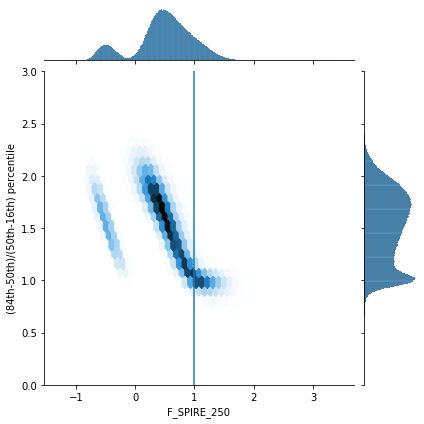

In [4]:
skew=(cat['FErr_SPIRE_250_u']-cat['F_SPIRE_250'])/(cat['F_SPIRE_250']-cat['FErr_SPIRE_250_l'])

ind=skew>5
skew[ind]=np.nan
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_250']),y=skew, kind='hex',ylim=(0,3))
g.ax_joint.axvline(x=np.log10(10))


For 250 $\mathrm{\mu m}$ depth is ~ 10mJy

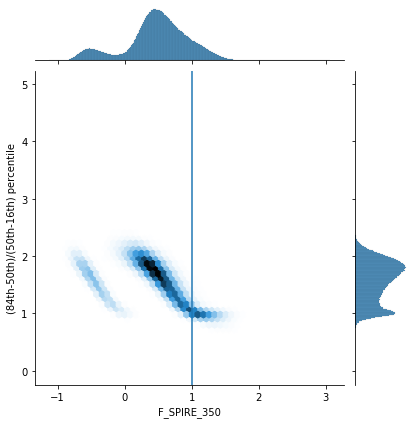

In [5]:
skew=(cat['FErr_SPIRE_350_u']-cat['F_SPIRE_350'])/(cat['F_SPIRE_350']-cat['FErr_SPIRE_350_l'])
ind=skew>5
skew[ind]=np.nan
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_350']),y=skew, kind='hex')
g.ax_joint.axvline(x=np.log10(10))

For 350 $\mathrm{\mu m}$ depth is ~ 10mJy

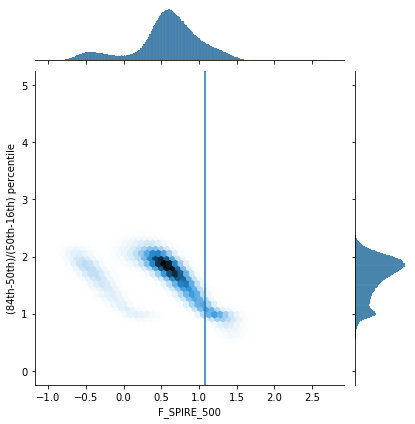

In [6]:
skew=(cat['FErr_SPIRE_500_u']-cat['F_SPIRE_500'])/(cat['F_SPIRE_500']-cat['FErr_SPIRE_500_l'])
ind=skew>5
skew[ind]=np.nan
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_500']),y=skew, kind='hex')
g.ax_joint.axvline(x=np.log10(12))

For 500 $\mathrm{\mu m}$ depth is ~ 12mJy

## Add flag to catalogue

In [7]:
from astropy.table import Column
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_250'))
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_350'))
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_500'))

In [8]:
ind_250=(cat['Pval_res_250']>0.5) | (cat['F_SPIRE_250'] < 10)
ind_350=(cat['Pval_res_350']>0.5) | (cat['F_SPIRE_350'] < 10)
ind_500=(cat['Pval_res_500']>0.5) | (cat['F_SPIRE_500'] < 12)

In [9]:
print(ind_250.sum(),ind_350.sum(),ind_500.sum(),len(cat))

1335896 1355293 1370033 1541342


In [10]:
cat['flag_spire_250'][ind_250]=True
cat['flag_spire_350'][ind_350]=True
cat['flag_spire_500'][ind_500]=True

In [11]:
cat.write('./data/dmu26_XID+SPIRE_GAMA-12_20210105.fits', format='fits',overwrite=True)

## Compare catalogue with old version

In [12]:
old_cat=Table.read('./data/dmu26_XID+SPIRE_GAMA-15_cat_20180416.fits')

In [13]:

comparison=join(cat, old_cat, join_type='left', keys='HELP_ID')


In [14]:
comparison[0:5]

HELP_ID,RA_1,Dec_1,F_SPIRE_250_1,FErr_SPIRE_250_u_1,FErr_SPIRE_250_l_1,F_SPIRE_350_1,FErr_SPIRE_350_u_1,FErr_SPIRE_350_l_1,F_SPIRE_500_1,FErr_SPIRE_500_u_1,FErr_SPIRE_500_l_1,Bkg_SPIRE_250_1,Bkg_SPIRE_350_1,Bkg_SPIRE_500_1,Sig_conf_SPIRE_250_1,Sig_conf_SPIRE_350_1,Sig_conf_SPIRE_500_1,Rhat_SPIRE_250_1,Rhat_SPIRE_350_1,Rhat_SPIRE_500_1,n_eff_SPIRE_250_1,n_eff_SPIRE_500_1,n_eff_SPIRE_350_1,Pval_res_250_1,Pval_res_350_1,Pval_res_500_1,flag_spire_250_1,flag_spire_350_1,flag_spire_500_1,RA_2,Dec_2,F_SPIRE_250_2,FErr_SPIRE_250_u_2,FErr_SPIRE_250_l_2,F_SPIRE_350_2,FErr_SPIRE_350_u_2,FErr_SPIRE_350_l_2,F_SPIRE_500_2,FErr_SPIRE_500_u_2,FErr_SPIRE_500_l_2,Bkg_SPIRE_250_2,Bkg_SPIRE_350_2,Bkg_SPIRE_500_2,Sig_conf_SPIRE_250_2,Sig_conf_SPIRE_350_2,Sig_conf_SPIRE_500_2,Rhat_SPIRE_250_2,Rhat_SPIRE_350_2,Rhat_SPIRE_500_2,n_eff_SPIRE_250_2,n_eff_SPIRE_500_2,n_eff_SPIRE_350_2,Pval_res_250_2,Pval_res_350_2,Pval_res_500_2,flag_spire_250_2,flag_spire_350_2,flag_spire_500_2
,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool
HELP_J140011.281+012223.464,210.04700380700902,1.3731843653253262,0.38164353,0.781658,0.114531204,0.47501397,0.9058693,0.15328023,0.59333813,1.088963,0.21446776,-0.08911292,-0.16872016,-0.40551266,0.009009672,0.012282081,0.019602988,0.9989484,1.000984,1.0005774,2778.272,2029.7217,2164.4585,0.0,0.0,0.0,True,True,True,210.04700380700902,1.3731843653253262,3.4050593,6.6121473,0.98657995,3.7339048,6.9894223,1.2680557,4.7656875,7.981601,1.6484989,-0.7286421,-1.341119,-3.2009892,0.078199215,0.10064748,0.15228304,0.9993539,0.99927664,0.99926007,2000.0,2000.0,2000.0,0.0,0.0,0.0,True,True,True
HELP_J140011.780+012459.432,210.04908433885802,1.4165089588858322,0.5146478,1.0363005,0.15605342,0.4511686,0.91904503,0.1312795,0.6386638,1.2022197,0.19619049,-0.08911292,-0.16872016,-0.40551266,0.009009672,0.012282081,0.019602988,0.9997022,0.99994224,0.99908024,2575.175,2688.5928,2840.0579,0.0,0.0,0.0,True,True,True,210.04908433885802,1.4165089588858322,3.9106286,7.4010973,1.2639616,3.8266573,7.150934,1.2433108,4.8233685,8.077788,1.5961202,-0.7286421,-1.341119,-3.2009892,0.078199215,0.10064748,0.15228304,0.99964976,0.999457,0.9989666,2000.0,2000.0,2000.0,0.0,0.0,0.0,True,True,True
HELP_J140012.393+012309.583,210.05163616447652,1.3859951494563272,0.25840268,0.57041967,0.07790935,0.25389123,0.56860316,0.065767676,0.31931356,0.68683344,0.1017476,-0.08911292,-0.16872016,-0.40551266,0.009009672,0.012282081,0.019602988,0.9987817,0.9991298,0.9998119,3186.2913,2541.1187,2535.072,0.0,0.0,0.0,True,True,True,210.05163616447652,1.3859951494563272,2.1839385,4.839487,0.596906,2.1921873,4.89577,0.6509393,3.010313,6.241596,0.8650414,-0.7286421,-1.341119,-3.2009892,0.078199215,0.10064748,0.15228304,1.000723,0.9998221,1.0005774,2000.0,2000.0,2000.0,0.0,0.0,0.0,True,True,True
HELP_J140012.790+012311.829,210.0532936292695,1.3866190856275589,0.21166283,0.49645355,0.05292122,0.22005937,0.5230947,0.055699106,0.29181927,0.6943955,0.079613276,-0.08911292,-0.16872016,-0.40551266,0.009009672,0.012282081,0.019602988,0.9982659,0.9992914,0.9999253,2711.4038,2504.2642,3151.912,0.0,0.0,0.0,True,True,True,210.0532936292695,1.3866190856275589,1.9832994,4.737705,0.5141957,2.0020022,4.3984294,0.55077815,2.744046,6.083789,0.7291209,-0.7286421,-1.341119,-3.2009892,0.078199215,0.10064748,0.15228304,1.0003047,0.9985206,0.9998363,2000.0,2000.0,2000.0,0.0,0.0,0.0,True,True,True

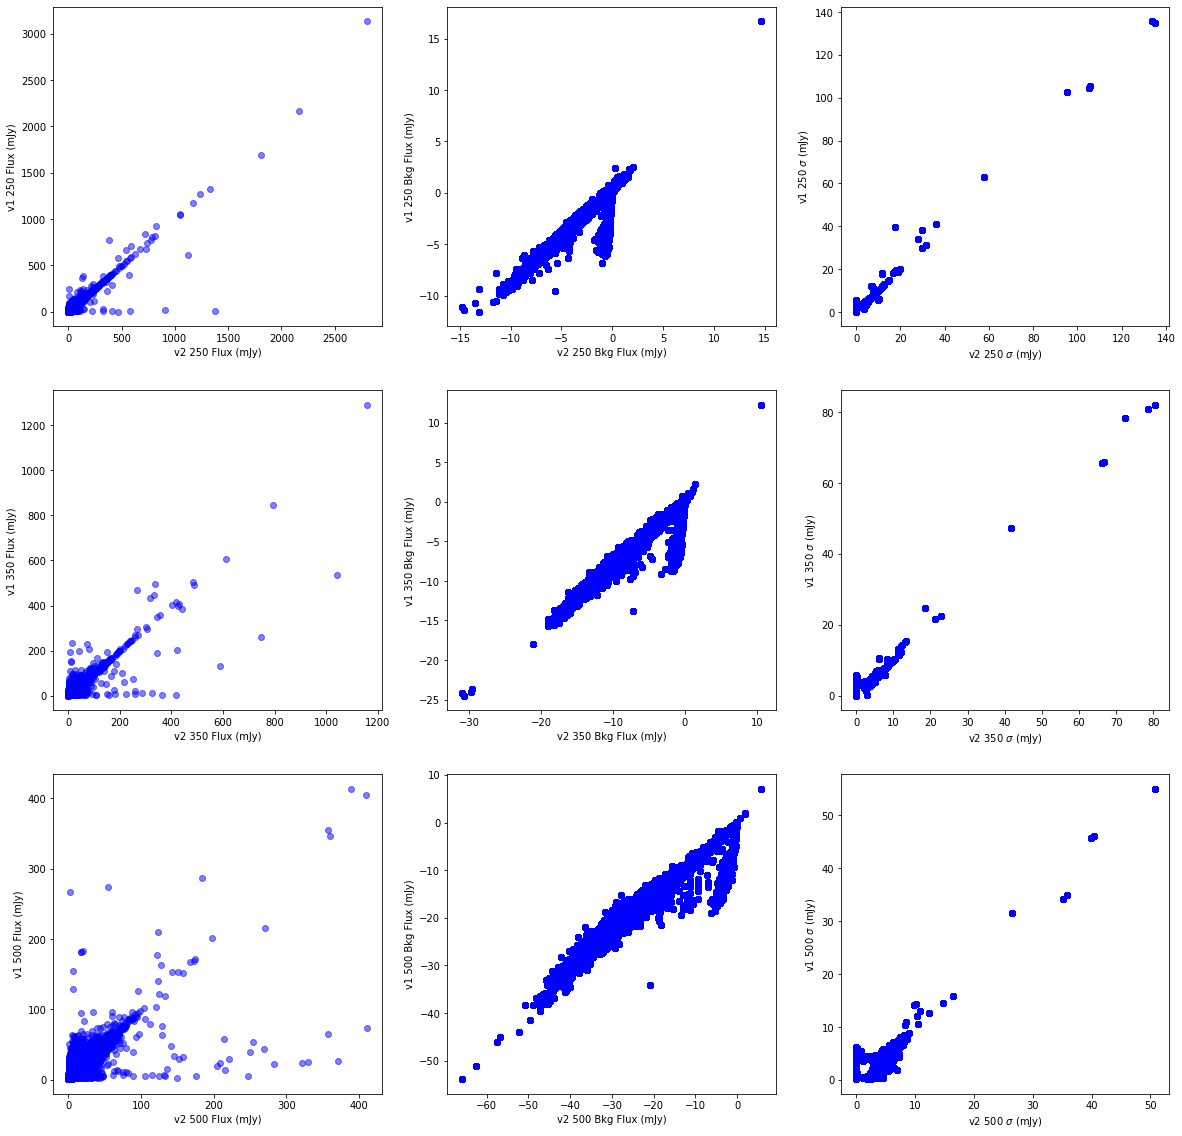

In [15]:
bands=[250,350,500]

fig,axes=plt.subplots(3,3,figsize=(20,20))
for i,b in enumerate(bands):
    axes[i,0].plot(comparison['F_SPIRE_{}_1'.format(b)],comparison['F_SPIRE_{}_2'.format(b)],'bo',alpha=0.5)
    axes[i,1].plot(comparison['Bkg_SPIRE_{}_1'.format(b)],comparison['Bkg_SPIRE_{}_2'.format(b)],'bo',alpha=0.5)
    axes[i,2].plot(comparison['Sig_conf_SPIRE_{}_1'.format(b)],comparison['Sig_conf_SPIRE_{}_2'.format(b)],'bo',alpha=0.5)
    
    axes[i,0].set_xlabel('v2 {} Flux (mJy)'.format(b))
    axes[i,0].set_ylabel('v1 {} Flux (mJy)'.format(b))
    
    axes[i,1].set_xlabel('v2 {} Bkg Flux (mJy)'.format(b))
    axes[i,1].set_ylabel('v1 {} Bkg Flux (mJy)'.format(b))
    
    axes[i,2].set_xlabel('v2 {} $\sigma$ (mJy)'.format(b))
    axes[i,2].set_ylabel('v1 {} $\sigma$ (mJy)'.format(b))

All looks good.